In [1]:
'''                                  ReadMe                                                      '''
'''# Nessa célula vamos apenas mudar a função geradora do estado a ser preparado                 '''
'''# Basta alterar a função que gera o estado, nesse caso target_op = init_state_ref(n_qubits, p)'''

from src.vqa_tools import general_vqacircuit_penny 
from src.state_initializer import  init_state_ref,init_state_bpf
from src.generalize import *
from torch import tensor
import numpy as np
import cmath
def state_amplitude_damping(theta, phi, p):
    state = np.zeros(4,dtype=complex)    
    state[0] = np.cos(theta/2)
    state[1] = np.sqrt(p)
    state[2] = np.sqrt(1-p)*cmath.exp(1j*phi)*np.sin(theta/2)
    target_op = np.outer(state.conj(), state)
    target_op = tensor(target_op)
    return target_op


def run_calcs(list_p, epochs):
    coerencias_R = []
    coerencias_L = []
    pretrain = True
    count = 0
    for p in list_p:
        print(f'{count} de {len(list_p)}')
        count += 1
        n_qubits, params, depht, n = start_things(2, 3)

        circuit, _ = general_vqacircuit_penny(n_qubits, depht)

        #_, target_op = init_state_ref(n_qubits, p)
        #_, target_op = init_state_bpf(n_qubits, p)
        target_op = state_amplitude_damping(np.pi/2, 0, p)

        qc, qr, params = optmize(epochs, n_qubits, circuit, params, target_op, pretrain)
        pretrain = False
        rho = tomograph(qc, qr)
        #print(rho)
        coerencias_L, coerencias_R = results(rho, coerencias_R, coerencias_L)

    plots(list_p, coerencias_R, coerencias_L)
    

# Results


[0.   0.25 0.5  0.75 1.  ]
0 de 5


/home/v/Desktop/Runtime-qiskit/src/generalize.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  parametros = tensor(best_params).detach().numpy()


1 de 5
2 de 5
3 de 5
4 de 5


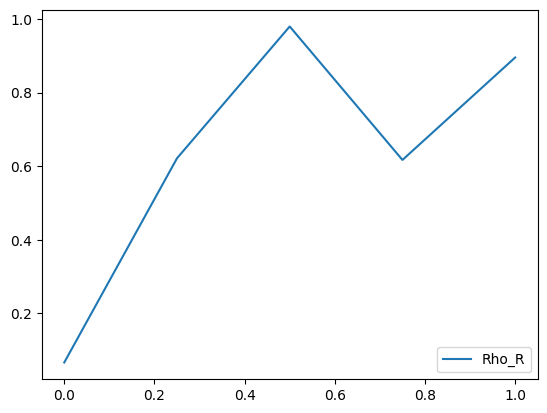

In [2]:
#list_p = [0,0.25,0.5,0.75,1]
list_p = np.linspace(0,1,5)
print(list_p)
run_calcs(list_p, 50)

In [14]:
list_p = np.linspace(0,1,5)
print(list_p)

[0.   0.25 0.5  0.75 1.  ]
